In [78]:
import numpy as np
import matplotlib.pyplot as plt
import orthopy,quadpy

As a prime basis, we will start with the hexahedral basis from (Wheeler, Xue & Yotov, 2012) which has a dimension of 24.

In [95]:
def WheelerXueYotov(x,y,z):
    V = np.zeros((3,x.size,24))
    O = np.zeros(x.size)
    for d in range(3):
        V[d,:,4*d+0] = np.ones(x.size)
        V[d,:,4*d+1] = x
        V[d,:,4*d+2] = y
        V[d,:,4*d+3] = z
    V[...,12] = [     x*z,     -y*z,        O] # curl(0       ,0       ,x*y*z   )
    V[...,13] = [   2*x*y,    -y**2,        O] # curl(0       ,0       ,x*y**2  )
    V[...,14] = [       O,   -2*x*z,        O] # curl(0       ,0       ,x**2*z  )
    V[...,15] = [  x**2*z, -2*x*y*z,        O] # curl(0       ,0       ,x**2*y*z)
    V[...,16] = [       O,      x*y,     -x*z] # curl(x*y*z   ,0       ,0       )
    V[...,17] = [       O,    2*y*z,    -z**2] # curl(y*z**2  ,0       ,0       )
    V[...,18] = [       O,        O,   -2*x*y] # curl(x*y**2  ,0       ,0       )
    V[...,19] = [       O,   x*y**2, -2*x*y*z] # curl(x*y**2*z,0       ,0       )
    V[...,20] = [    -x*y,        O,      y*z] # curl(0       ,x*y*z   ,0       )
    V[...,21] = [   -x**2,        O,    2*x*z] # curl(0       ,x**2*z  ,0       )
    V[...,22] = [  -2*y*z,        O,        O] # curl(0       ,y*z**2  ,0       )
    V[...,23] = [-2*x*y*z,        O,   y*z**2] # curl(0       ,x*y*z**2,0       ) 
    return V

We have 4 of 6 constraints for this hexahedral space to restrict it to a prismatic space. Here I will construct a constraint matrix which has these 4 constraints as well as moments which effectively remove the terms we want on each face.

In [96]:
C = np.zeros((22,24))
nc = 0

### Top Face

In [97]:
# quadrature for the top face of the prism
scheme = quadpy.triangle.seven_point()
quad   = scheme.points @ np.asarray([[-1,-1],[+1,-1],[-1,+1]]) # to cartesian
xq,yq  = quad[:,0],quad[:,1]; zq = np.ones(xq.shape)
bary   = np.asarray([(xq+1)/2,(yq+1)/2,1-(xq+1)/2-(yq+1)/2]) # to barycentric
poly   = orthopy.triangle.tree(bary,3,"normal")[2] # orthogonal to {1,x,y} but not {xy}
which_poly = 0 # could also be 2, but not 1

P = WheelerXueYotov(xq,yq,zq)
for j in range(P.shape[2]):
    C[0,j] = ((P[...,j].T @ [0,0,+1])*poly[which_poly]  *scheme.weights).sum() # no xy
    C[1,j] = ((P[...,j].T @ [0,0,+1])*(np.ones(xq.size))*scheme.weights).sum() # no 1
    C[2,j] = ((P[...,j].T @ [0,0,+1])*(              xq)*scheme.weights).sum() # no x
    C[3,j] = ((P[...,j].T @ [0,0,+1])*(              yq)*scheme.weights).sum() # no y
nc += 4

### Bottom Face

In [98]:
zq *= -1
P   = WheelerXueYotov(xq,yq,zq)
for j in range(P.shape[2]):
    C[4,j] = ((P[...,j].T @ [0,0,-1])*poly[which_poly]*scheme.weights).sum()   # no xy
    C[5,j] = ((P[...,j].T @ [0,0,-1])*(np.ones(xq.size))*scheme.weights).sum() # no 1
    C[6,j] = ((P[...,j].T @ [0,0,-1])*(              xq)*scheme.weights).sum() # no x
    C[7,j] = ((P[...,j].T @ [0,0,-1])*(              yq)*scheme.weights).sum() # no y
nc += 4

### Front Face

In [99]:
x1d,w1d = np.polynomial.legendre.leggauss(7)
x2d,y2d = np.meshgrid(x1d,x1d); x2d = x2d.flatten(); y2d = y2d.flatten()
w2d = (w1d[:,np.newaxis]*w1d).flatten()
Xq  = np.asarray([-1,-1,-1])[:,np.newaxis] * (0.25*(1-x2d)*(1-y2d))
Xq += np.asarray([+1,-1,-1])[:,np.newaxis] * (0.25*(1+x2d)*(1-y2d))
Xq += np.asarray([-1,-1,+1])[:,np.newaxis] * (0.25*(1-x2d)*(1+y2d))
Xq += np.asarray([+1,-1,+1])[:,np.newaxis] * (0.25*(1+x2d)*(1+y2d))
xq  = Xq[0,:]; yq = Xq[1,:]; zq = Xq[2,:]
P   = WheelerXueYotov(xq,yq,zq)
C[ 8,:] = ((P.T @ [0,-1,0]) * (np.ones(x2d.size)) * w2d).sum(axis=1) # no 1
C[ 9,:] = ((P.T @ [0,-1,0]) * (              x2d) * w2d).sum(axis=1) # no s
C[10,:] = ((P.T @ [0,-1,0]) * (              y2d) * w2d).sum(axis=1) # no z
C[11,:] = ((P.T @ [0,-1,0]) * (          x2d*y2d) * w2d).sum(axis=1) # no s*z
nc += 4

### Left Face

In [100]:
x1d,w1d = np.polynomial.legendre.leggauss(7)
x2d,y2d = np.meshgrid(x1d,x1d); x2d = x2d.flatten(); y2d = y2d.flatten()
w2d = (w1d[:,np.newaxis]*w1d).flatten()
Xq  = np.asarray([-1,+1,-1])[:,np.newaxis] * (0.25*(1-x2d)*(1-y2d))
Xq += np.asarray([-1,-1,-1])[:,np.newaxis] * (0.25*(1+x2d)*(1-y2d))
Xq += np.asarray([-1,+1,+1])[:,np.newaxis] * (0.25*(1-x2d)*(1+y2d))
Xq += np.asarray([-1,-1,+1])[:,np.newaxis] * (0.25*(1+x2d)*(1+y2d))
xq  = Xq[0,:]; yq = Xq[1,:]; zq = Xq[2,:]
P   = WheelerXueYotov(xq,yq,zq)
C[12,:] = ((P.T @ [-1,0,0]) * (np.ones(x2d.size)) * w2d).sum(axis=1) # no 1
C[13,:] = ((P.T @ [-1,0,0]) * (              x2d) * w2d).sum(axis=1) # no s
C[14,:] = ((P.T @ [-1,0,0]) * (              y2d) * w2d).sum(axis=1) # no z
C[15,:] = ((P.T @ [-1,0,0]) * (          x2d*y2d) * w2d).sum(axis=1) # no s*z
nc += 4

### Diagonal Face

In [101]:
x1d,w1d = np.polynomial.legendre.leggauss(7)
x2d,y2d = np.meshgrid(x1d,x1d); x2d = x2d.flatten(); y2d = y2d.flatten()
w2d = (w1d[:,np.newaxis]*w1d).flatten()
poly = orthopy.quadrilateral.tree(np.asarray([x2d,y2d]),3) # on [-1,+1]^2
orth = [poly[2][0],poly[3][1]]

Xq  = np.asarray([+1,-1,-1])[:,np.newaxis] * (0.25*(1-x2d)*(1-y2d))
Xq += np.asarray([-1,+1,-1])[:,np.newaxis] * (0.25*(1+x2d)*(1-y2d))
Xq += np.asarray([+1,-1,+1])[:,np.newaxis] * (0.25*(1-x2d)*(1+y2d))
Xq += np.asarray([-1,+1,+1])[:,np.newaxis] * (0.25*(1+x2d)*(1+y2d))
xq  = Xq[0,:]; yq = Xq[1,:]; zq = Xq[2,:]

P   = WheelerXueYotov(xq,yq,zq)
s   = 1/np.sqrt(2)
C[16,:] = ((P.T @ [s,s,0]) * orth[0] * w2d).sum(axis=1) # no s**2
C[17,:] = ((P.T @ [s,s,0]) * orth[1] * w2d).sum(axis=1) # no zs**2
C[18,:] = ((P.T @ [s,s,0]) * (np.ones(x2d.size)) * w2d).sum(axis=1) # no 1
C[19,:] = ((P.T @ [s,s,0]) * (              x2d) * w2d).sum(axis=1) # no s
C[20,:] = ((P.T @ [s,s,0]) * (              y2d) * w2d).sum(axis=1) # no z
C[21,:] = ((P.T @ [s,s,0]) * (          x2d*y2d) * w2d).sum(axis=1) # no s*z
nc += 6

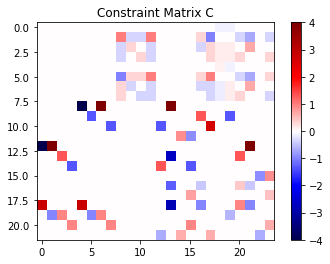

Singular values: [8.37687358 7.0569892  3.74627962 3.35751189 2.76836448 2.75235423
 2.226561   2.06841529 1.92058841 1.44439676 1.25991747 1.21214716
 0.76824673 0.64354799 0.59723891 0.51644055 0.49139238 0.40390908
 0.30012345 0.22944445 0.06716129 0.06562599]


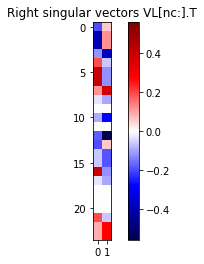

In [102]:
c = C[:nc]
mag = np.abs(c).max()
cb = plt.imshow(c,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.title("Constraint Matrix C")
plt.show()

UL,SL,VL = np.linalg.svd(c)
print("Singular values:",SL)

VL = VL[nc:,:]
mag = np.abs(VL).max()
cb = plt.imshow(VL.T,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.title("Right singular vectors VL[nc:].T")
plt.show()